## Import statements and loading the data

In [1]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

2025-05-05 01:48:23.414782: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
f = h5py.File('bird_spectrograms.hdf5', 'r')
list(f.keys())

['amecro',
 'amerob',
 'bewwre',
 'bkcchi',
 'daejun',
 'houfin',
 'houspa',
 'norfli',
 'rewbla',
 'sonspa',
 'spotow',
 'whcspa']

In [3]:
for key in list(f.keys()):
    print(f[key].shape)

(128, 517, 66)
(128, 517, 172)
(128, 517, 144)
(128, 517, 45)
(128, 517, 125)
(128, 517, 84)
(128, 517, 630)
(128, 517, 37)
(128, 517, 187)
(128, 517, 263)
(128, 517, 137)
(128, 517, 91)


In [4]:
# set seeds to ensure reproducibility 
np.random.seed(5322)
tf.random.set_seed(5322)
random.seed(5322)

## Binary Classification (Song Sparrow and House Sparrow)
- Just because these two species have the most samples in our dataset

In [5]:
# picked the two species with most samples for binary classifcation model
# sonspa = song sparrow, houspa = house sparrow
X1 = np.array(f['sonspa'])
X2 = np.array(f['houspa'])

In [6]:
# create labels. 0 for song sparrow, 1 for house sparrow
y1 = np.zeros(X1.shape[2])
y2 = np.ones(X2.shape[2])

In [7]:
# combine into one set
X = np.concatenate((X1, X2), axis = 2)
y = np.concatenate((y1, y2))

In [8]:
# X has shape (128, 517, total_samples)
# we need to format input like (total_samples, 128, 517, channels = 1 not 3 since not rgb)
X = np.transpose(X, (2, 0, 1))
X = X[..., np.newaxis]
# X is now (total_samples, 128, 517, 1)

In [9]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5322, stratify = y)

# normalize data
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

## First simple model 7 total layers
- no l2 regularization yet
- no dropout
- (2, 2) max pooling to take max val of 2x2 windows
- flatten layer

In [ ]:
# our first and simplest cnn for binary classification
model = Sequential([
    # layer group 1
    Conv2D(16, (3,3), activation = 'relu', input_shape = (128, 517, 1)),
    MaxPooling2D(2, 2),
    # layer group 2
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2, 2),
    # flatten layer
    Flatten(),
    # dense layers
    Dense(units = 64, activation = 'relu'),
    Dense(units = 1, activation = 'sigmoid')
], name = "Binary_Model_1")

# compile model
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

# model summary
model.summary()

# train model
history = model.fit(
    X_train, y_train,
    epochs = 10,
    batch_size = 16,
    validation_split = 0.2
)

# test the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_acc}')

Model: "Binary_Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 515, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 257, 16)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 255, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 127, 32)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 121920)            0         
                                                                 
 dense (Dense)               (None, 64)             

This simple model does decent given its simplicity\
 ~70% Train, test, and validation accuracies indicates good generalization, but also that we need more tuning obviously\
 Hard to tell if model is overfitting because of the similar accuracies\
 The model also seems to converge early on, so add early stopping to not run useless epochs and save time\
 Another important thing is the number of parameters in the dense layer. 7.8 million parameters is crazy given our dataset size, so add something like global average pooling 2d to reduce to a reasonable number\
 Overall, decent simple model, but needs more complexity and tuning

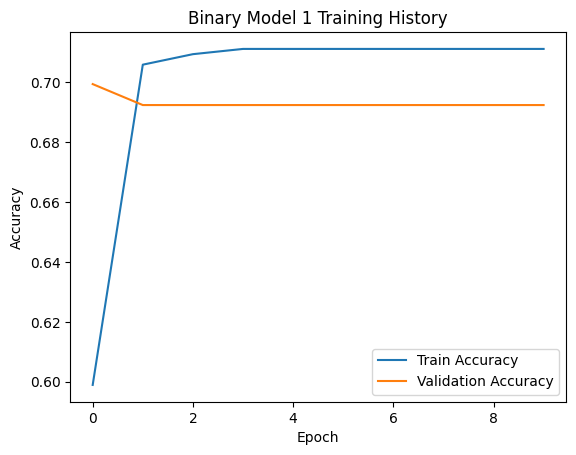

In [11]:
# visualize training accuracy versus validation accuracy
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Binary Model 1 Training History')
plt.show()

## Second model with improvements/adjustments 13 total layers
- added another layer "group" for complexity
- added 0.01 l2 regularization to discourage large weights
- added 30% dropout to help with overfitting and regularization
- also included global average pooling 2D instead of flatten to keep the number of parameters at each layer reasonable
- added early stopping since previous model converged early on
- also increased the number of epochs to allow the model to possibly improve accuracy

In [ ]:
# our second cnn for binary classification
model = Sequential([
    # layer group 1
    Conv2D(16, (3, 3), activation = 'relu', input_shape = (128, 517, 1), kernel_regularizer = l2(0.01)),
    MaxPooling2D(pool_size = (2, 2)),
    Dropout(rate = 0.3),
    # layer group 2
    Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer = l2(0.01)),
    MaxPooling2D(pool_size = (2, 2)),
    Dropout(rate = 0.3),
    # layer group 3
    Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.01)),
    MaxPooling2D(pool_size = (2, 2)),
    Dropout(rate = 0.3),
    # pooling to keep # of parameters in check
    GlobalAveragePooling2D(),
    # dense layers
    Dense(units = 64, activation = 'relu', kernel_regularizer = l2(0.01)),
    Dropout(rate = 0.3),
    Dense(units = 1, activation = 'sigmoid')
], name = "Binary_Model_2")

# compile model
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

# model summary
model.summary()

# early stopping since previous model did not improve after 3rd/4th epoch
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

# train the model
history = model.fit(
    X_train, y_train,
    epochs = 30,
    batch_size = 16,
    validation_split = 0.2,
    callbacks = [early_stopping]
)

# evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_acc}')

Model: "Binary_Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 515, 16)      160       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 257, 16)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 63, 257, 16)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 255, 32)       4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 127, 32)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 127, 32)    

Somehow did worse with adjustments. Might need to make more drastic tuning changes\
This model definitely overfit seen with the higher training accuracy and much lower validation accuracy\
Performed worse than random guessing\
At least early stopping worked\
Might need to add more layers\
Change regularization weight to try and prevent overfitting even more\
Maybe adjust dropout rate to scale with filter sizes

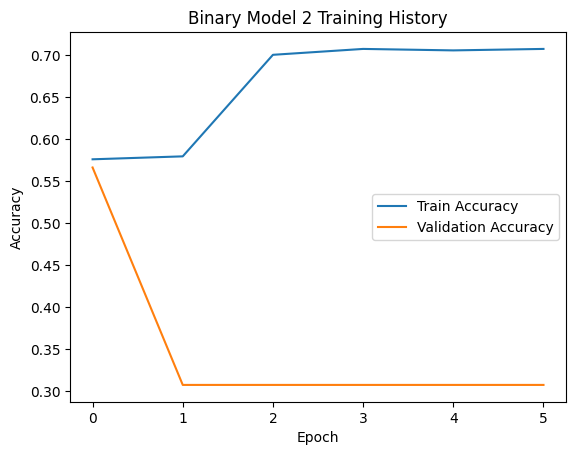

In [13]:
# visualize training accuracy versus validation accuracy
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Binary Model 2 Training History')
plt.show()

## Final binary model with even more improvements/adjustments 24 total layers
- added a couple more layers for more complexity
- started the filter size at 32 instead of 16
- modified the dropouts at each layer to scale with filter sizes as they increase
- change l2 regularization to 0.0001 from 0.01 to prevent overfitting a little bit
- reduced the adam optimizer learning rate to allow for better convergence
- added batch normalization to stabilize and speed up training a little bit given we added more layers
- kept padding to be 'same' to retain more spatial information and details from our input as layer size increases. helps given small input sizes
- reduced stopping patience to 3 in case continous non improvement like previous model
- tried label smoothing so instead of comparing predictions with 0 and 1, it compares with 0.05 and 0.95

In [ ]:
# final more complex cnn for binary classification with additional layers
model = Sequential([
    # layer group 1
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 517, 1), kernel_regularizer = l2(0.0001), padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    # layer group 2
    Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.0001), padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    # layer group 3
    Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = l2(0.0001), padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    # layer group 4
    Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = l2(0.0001), padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    # layer group 5
    Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer = l2(0.0001), padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),
    # keep # of params in check
    GlobalAveragePooling2D(),
    # dense layers
    Dense(units = 128, activation = 'relu', kernel_regularizer = l2(0.0001)),
    Dropout(0.4),
    Dense(units = 1, activation = 'sigmoid')
], name = "Binary_Model_3")

# compile the model with lower learning rate
model.compile(
    optimizer = Adam(learning_rate = 0.0001),
    loss = BinaryCrossentropy(label_smoothing = 0.05),
    metrics = ['accuracy']
)

# model summary
model.summary()

# early stopping with less patience
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

# train the model
history = model.fit(
    X_train, y_train,
    epochs = 30,
    batch_size = 16,
    validation_split = 0.2,
    callbacks = [early_stopping]
)

# evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_acc}')

Model: "Binary_Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 517, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 128, 517, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 258, 32)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 64, 258, 32)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 258, 64)       18496     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 258, 64)    

Much more stable model with much better accuracy than previous 2 with the gradual and progressive learning\
Great accuracy ~84% on test set\
Seems the additional layers, the label smoothing, lower l2 regularization, scaling dropout, same padding, batch normalization, and smaller learning rate helped improve the model significantly\
No signs of overfitting either which is amazing\
Used almost all 30 epochs, too

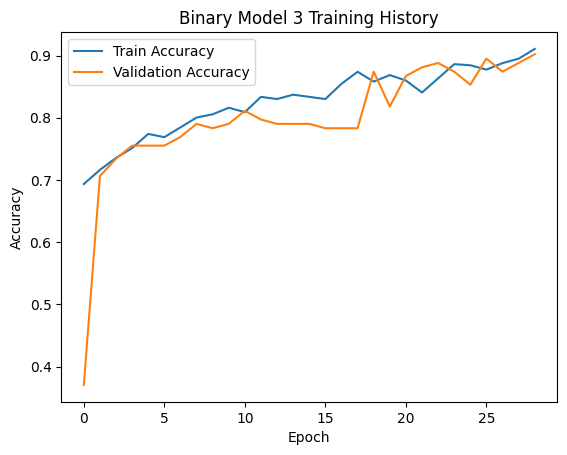

In [15]:
# visualize training accuracy versus validation accuracy
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Binary Model 3 Training History')
plt.show()

Beautiful

## Multiclass Classification (All species)

In [16]:
# combine data into one dataset
X = np.concatenate([np.array(f[species]) for species in list(f.keys())], axis = 2)
y = np.concatenate([np.full(f[species].shape[2], index) for index, species in enumerate(list(f.keys()))])

In [17]:
# X has shape (128, 517, total_samples)
# we need to format input like (total_samples, 128, 517, channels = 1 not 3 since not rgb)
X = np.transpose(X, (2, 0, 1))
X = X[..., np.newaxis]
# X is now (total_samples, 128, 517, 1)

In [18]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5322, stratify = y)

# noramlize data
X_train = X_train / np.max(X_train)
X_test  = X_test / np.max(X_test)